# Аналитика событий и A/B тестирование в мобильном приложении

Данные из мобильного приложения, который продаёт продукты питания. Задача - выяснить, как ведут себя пользователи мобильного приложения.   
Предложение - поменять шрифты во всём приложении. Был проведен A/A/B-тест. Нужно проанализировать воронку продаж и выяснить, какой шрифт лучше.


Каждая запись — это действие пользователя, или событие.   
Данные содержат название события, уникальный номер пользователя, время, номер эксперимента.

### Содержание проекта

## 1. Загрузка библиотек и данных <a id="start"></a>

In [1]:
pip install seaborn --upgrade

Requirement already up-to-date: seaborn in ./opt/anaconda3/lib/python3.8/site-packages (0.11.1)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install plotly --upgrade

Requirement already up-to-date: plotly in ./opt/anaconda3/lib/python3.8/site-packages (4.14.3)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import pylab as pl
import numpy as np
from IPython.display import display
import plotly.express as px 
import datetime as dt
from scipy import stats as st
import plotly.express as px
import math as mth
import cmath as cmth
import seaborn as sns
from plotly import graph_objects as go
import pandas as pd
import plotly.io as pio
pio.renderers.default = "svg"
pd.options.mode.chained_assignment = None 

In [4]:
logs = pd.read_csv('logs_exp.csv', sep ='\t')

In [5]:
logs

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [6]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


### Вывод <a id="conc0"></a>

Всего 244126 наблюдений. Пропущенные данные отсутствуют. Необходимо заменить названия переменных и преобразовать переменную с временем событий в формат даты. Также нужно проверить данные на дубликаты. 

## Подготовка и изучение данных <a id="preprocessing"></a>

Переименуем переменные:

In [7]:
logs = logs.rename(columns={"EventName": 'event',"DeviceIDHash":'id',"EventTimestamp":'time',"ExpId":'group'})

Изменим тип переменной time на формат даты и времени:

In [8]:
logs['time'] = pd.to_datetime(logs['time'], unit='s')

Создадим дополнительную переменную с датой события:

In [9]:
logs['date'] = logs['time'].dt.date

Проверим данные на дубликаты:

In [10]:
logs.duplicated().value_counts()

False    243713
True        413
dtype: int64

Всего найдено 413 дубликатов. Возможно, что в сборе данных произошла ошибка и поэтому некоторые пользователи были учтены несколько раз. Для избежания искажения результатов анализа удалим данные дубликаты.

In [11]:
logs = logs.drop_duplicates()

In [12]:
len(logs['id'].unique())

7551

Данные содержат информацию о 7551 уникальных пользователях

In [13]:
logs_group = logs.groupby(['id']).agg({'event':'nunique'})
logs_group['event'].mean()

2.6744802012978415

В среднем на одного пользователя приходится 2.7 событий.

In [14]:
print(logs['date'].min())
print(logs['date'].max())

2019-07-25
2019-08-07


Данные собраны за период с 25 июля 2019 по 7 августа 2019 года. Далее рассмотрим гистограмму по дате и времени.

Text(0.5, 0, 'Дата')

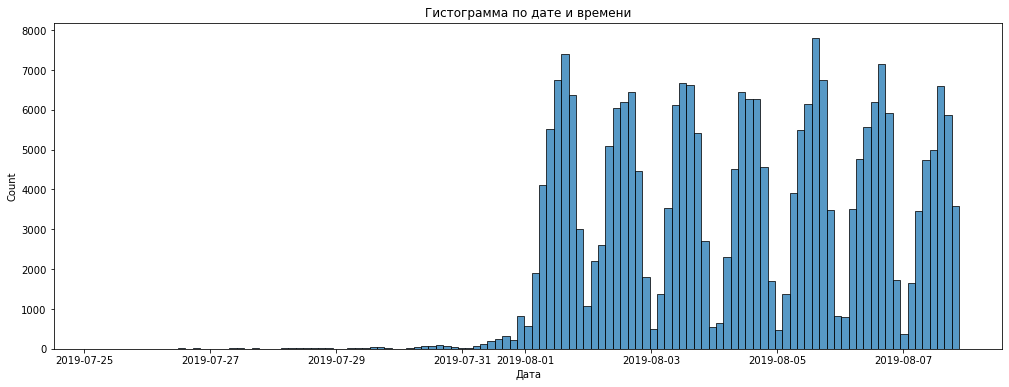

In [15]:
plt.figure(figsize=(17, 6))
n = sns.histplot(data=logs, x="time")
plt.title('Гистограмма по дате и времени')
plt.xlabel('Дата')

Можно заметить, что данные практически отсутствуют до 1 августа 2019 года. Поэтому будем учитывать данные с 1.08.2019

In [16]:
logs = logs[logs['time']>'2019-08-01']

In [17]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2828 to 244125
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   event   240887 non-null  object        
 1   id      240887 non-null  int64         
 2   time    240887 non-null  datetime64[ns]
 3   group   240887 non-null  int64         
 4   date    240887 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.0+ MB


Text(0.5, 0, 'Дата')

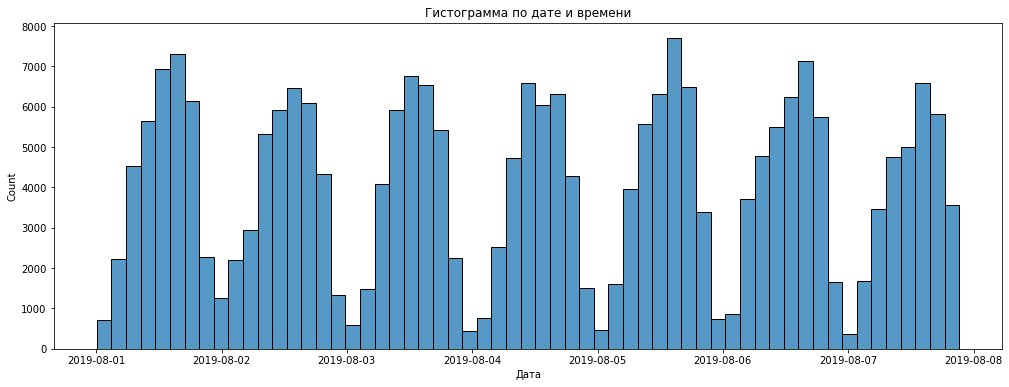

In [18]:
plt.figure(figsize=(17, 6))
n = sns.histplot(data=logs, x="time")
plt.title('Гистограмма по дате и времени')
plt.xlabel('Дата')

In [19]:
logs['group'].value_counts()

248    84563
246    79302
247    77022
Name: group, dtype: int64

In [20]:
len(logs['id'].unique())

7534

Проверим, есть ли пользователи, которые видели разные версии приложения.

In [21]:
(logs.groupby('id').group.nunique() > 1).unique()

array([False])

Таких пользователей не обнаружено.

## Вывод <a id="conc1"></a>

Данные содержали дубликаты, поэтому их необходимо было убрать. Также по некоторым дням практически отсутствовала информация. Это может «перекашивать данные».
   
Таким образом, данные сократились до 240887 наблюдений. При этом количество уникальных пользователей сократилось незначительно - до 7534. Новые данные содержат информацию о пользователях из всех групп. Нет пользователей, которые видели обе версии сайта. 

## Воронка событий <a id="convers"></a>

* **Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.** <a id="quest1"></a>

In [22]:
log1= logs.groupby(['event']).agg({'event':'count'})
log1 = log1.rename(columns={"event":'count'})
display(log1.sort_values(by='count', ascending=False))

,count
event,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


В логах встречаются следующий события: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, Tutorial. Самым частым событием является MainScreenAppear. Меньше всего - Tutorial.

* **Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.** <a id="quest2"></a>

In [23]:
logs1= logs.groupby(['event']).agg({'id':'nunique'}).reset_index()
logs1 = logs1.sort_values(by='id',ascending=False)

In [24]:
logs1['ratio']=logs1['id']/len(logs['id'].unique())*100
logs1.round(2)

,event,id,ratio
1,MainScreenAppear,7419,98.47
2,OffersScreenAppear,4593,60.96
0,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


В столбце id указано, сколько пользователей совершили каждое из событий. 98,47% пользователей хотя бы раз совершали событие MainScreenAppear. И только 11,15% проходили Tutorial. 

Для дальнейшего анализа не будем учитывать событие Tutorial, так как большая часть пользователей пропускает данный шаг и он не является одним из основных. 

In [25]:
logs1=logs1[logs1['event']!='Tutorial']

Построим воронку событий.

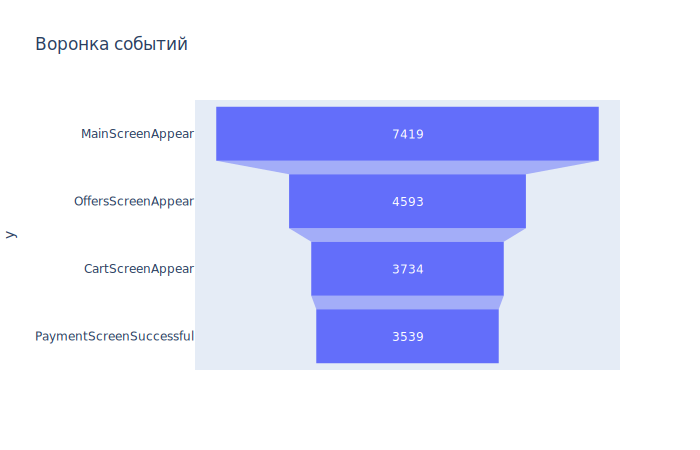

In [26]:
fig = px.funnel(x = logs1['id'], y=logs1['event'], title='Воронка событий')
fig.show()

* **Определим, в каком порядке происходят события.** <a id="quest3"></a>

Можно предположить, что сначала пользователи открывают приложение и им предлагается воспользоваться руководством по использованию приложения(Tutorial), затем, после прохождения или отказа прохождения tutorial, пользователи видят главный экран (MainScreenAppear), далее ознакамливаются с каталогом приложения (OffersScreenAppear). После выбора продукции из каталога они переходят в корзину (CartScreenAppear), а далее совершают оплату (PaymentScreenSuccessful).

Получается, что по количеству пользователей можно увидеть, что все события выстраиваются в последовательную цепочку, кроме событий по показу руководства для пользователей.

* **По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). Для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.** <a id="quest4"></a>

In [27]:
users = logs.pivot_table(index='id', columns='event', values='time',aggfunc='min') 

In [28]:
step_1 = ~users['MainScreenAppear'].isna()
step_2 = step_1 & (users['OffersScreenAppear'] > users['MainScreenAppear'])
step_3 = step_2 & (users['CartScreenAppear'] > users['OffersScreenAppear'])
step_4 = step_3 & (users['PaymentScreenSuccessful'] > users['CartScreenAppear'])

In [29]:
main_screen = users[step_1].shape[0]
offers = users[step_2].shape[0]
cart = users[step_3].shape[0]
payment = users[step_4].shape[0]

print('Просмотрели главную страницу:', main_screen)
print('Просмотрели каталог:', offers)
print('Просмотрели корзину:', cart)
print('Оплатили:', payment)

Просмотрели главную страницу: 7419
Просмотрели каталог: 4201
Просмотрели корзину: 1767
Оплатили: 454


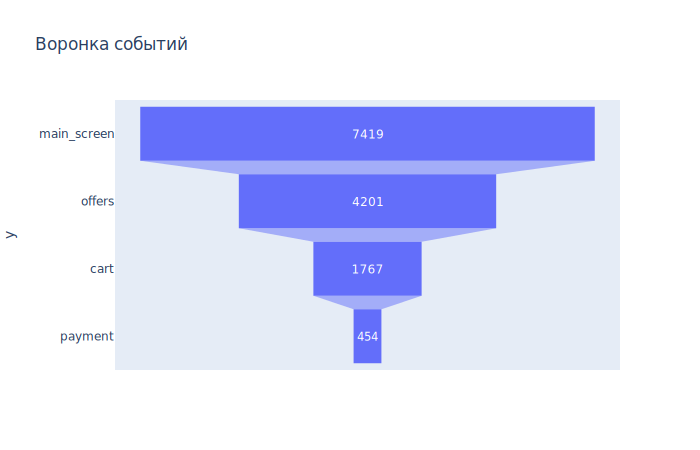

<Figure size 360x1440 with 0 Axes>

In [30]:
plt.figure(figsize=(5, 20))
fig = px.funnel(x=[main_screen,offers,cart,payment],y=['main_screen','offers','cart','payment'], title='Воронка событий')
fig.show()

In [31]:
print('Просмотрели главную страницу: {:.2%}'.format(main_screen/main_screen))
print('Просмотрели каталог: {:.2%}'.format(offers/main_screen))
print('Просмотрели корзину: {:.2%}'.format(cart/offers))
print('Оплатили {:.2%}'.format(payment/cart))

Просмотрели главную страницу: 100.00%
Просмотрели каталог: 56.62%
Просмотрели корзину: 42.06%
Оплатили 25.69%


Посмотрим доли пользователей для всех событий по отношению к первому событию. Узнаем, сколько всего пользователей при последовательных действиях доходят до конца. 

In [32]:
print('Просмотрели главную страницу: {:.2%}'.format(main_screen/main_screen))
print('Просмотрели каталог: {:.2%}'.format(offers/main_screen))
print('Просмотрели корзину: {:.2%}'.format(cart/main_screen))
print('Оплатили {:.2%}'.format(payment/main_screen))

Просмотрели главную страницу: 100.00%
Просмотрели каталог: 56.62%
Просмотрели корзину: 23.82%
Оплатили 6.12%


Только 6.12% пользователей доходят до последнего этапа. 

In [33]:
logs1['conversion']=((logs1['id'].pct_change()+1)*100).round(2)
logs1['conversion']=logs1['conversion'].replace(np.nan,100)

In [34]:
logs1

,event,id,ratio,conversion
1,MainScreenAppear,7419,98.473586,100.00
2,OffersScreenAppear,4593,60.963632,61.91
0,CartScreenAppear,3734,49.561986,81.30
3,PaymentScreenSuccessful,3539,46.973719,94.78


Больше всего пользователей теряется на этапе перехода к событию OffersScreenAppear (около 38%).

### Вывод <a id="conc2"></a>

При последовательной хронологии событий только 6.12% всех пользователей доходят до последнего этапа (484 пользователя). В предыдущем пункте было рассчитано, что всего через этап оплаты прошли 3539 пользователей. Таким образом, часть пользователей может пропускать какие-то этапы и не соблюдает последовательность описанных выше событий. Проблемы есть на этапе перехода к экрану с предложениями - можно сообщить команде и дизайнерам, что есть какое-то слабое место и пользователи возможно не замечают кнопку перехода. 

## Результаты эксперимента <a id="experiment"></a>

* **Сколько пользователей в каждой экспериментальной группе?** <a id="exp1"></a>

In [35]:
logs.groupby(['group']).agg({'id':'nunique'})

,id
group,
246,2484
247,2513
248,2537


В группе 246 2484 пользователя, в группе 247 - 2513, в группе 248 - 2537.

* **Проверим, находят ли статистические критерии разницу между выборками 246 и 247.**

* **Рассмотрим самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие.**
<a id="exp2"></a>

In [36]:
groups = logs.pivot_table(index = ['group'], columns = 'event',values = 'id',aggfunc = 'nunique').reset_index()
groups = groups.drop(columns = 'Tutorial')

In [37]:
first = logs[logs['group']==246]
first = first[first['event'] !='Tutorial']
first = first.groupby(['event']).agg({'id':'nunique'}).reset_index()
first = first.sort_values(by='id', ascending = False)
first

,event,id
1,MainScreenAppear,2450
2,OffersScreenAppear,1542
0,CartScreenAppear,1266
3,PaymentScreenSuccessful,1200


In [38]:
second = logs[logs['group']==247]
second = second[second['event'] !='Tutorial']
second = second.groupby(['event']).agg({'id':'nunique'}).reset_index()
second = second.sort_values(by='id', ascending = False)
second

,event,id
1,MainScreenAppear,2476
2,OffersScreenAppear,1520
0,CartScreenAppear,1238
3,PaymentScreenSuccessful,1158


In [39]:
initial_user=logs.groupby(['group']).agg({'id':'nunique'}).reset_index()
initial_user

,group,id
0,246,2484
1,247,2513
2,248,2537


In [40]:
merged = first.merge(second, on='event')
merged = merged.rename(columns = {'id_x':'id_246','id_y':'id_247'})

In [41]:
merged['ratio_246']= merged['id_246']/2484
merged['ratio_247']= merged['id_247']/2513
merged['difference'] = ((merged['id_246']/merged['id_247']-1)*100).round(2)
merged['difference_ratio'] = ((merged['ratio_246']- merged['ratio_247'])*100).round(2)

In [42]:
merged

,event,id_246,id_247,ratio_246,ratio_247,difference,difference_ratio
0,MainScreenAppear,2450,2476,0.986312,0.985277,-1.05,0.10
1,OffersScreenAppear,1542,1520,0.620773,0.604855,1.45,1.59
2,CartScreenAppear,1266,1238,0.509662,0.492638,2.26,1.70
3,PaymentScreenSuccessful,1200,1158,0.483092,0.460804,3.63,2.23


Количество пользователей по событиям между 246 и 247 группой не отличается более, чем на 2,23%.

Самым популярным событием является просмотр главного экрана (MainScreenAppear).

In [43]:
groups = logs.pivot_table(index='group',columns ='event',values='id',aggfunc='nunique').reset_index()

In [44]:
groups = groups.drop(columns='Tutorial')

In [45]:
gr1 = groups[['group','MainScreenAppear']]
gr1 = gr1.merge(initial_user, on='group')
gr1['ratio']=(gr1['MainScreenAppear']/gr1['id']*100).round(2)

In [46]:
gr1

,group,MainScreenAppear,id,ratio
0,246,2450,2484,98.63
1,247,2476,2513,98.53
2,248,2493,2537,98.27


В обеих группах более 98% всех пользователей просматривали главный экран.

Проверим, есть ли статистическое различие между контрольными группами для этого события. Для этого проведем z-тест.

alpha = 0.05

**H0:** Между долями различий нет

**H1:** Между долями есть значимая разница

In [47]:
p1 = gr1['MainScreenAppear'][0]/gr1['id'][0]
p2 = gr1['MainScreenAppear'][1]/gr1['id'][1]

In [48]:
p_combined = (gr1['MainScreenAppear'][0] + gr1['MainScreenAppear'][1]) / (gr1['id'][0] + gr1['id'][1])

In [49]:
difference = p1 - p2 

In [50]:
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/gr1['id'][0] + 1/gr1['id'][1]))
distr = st.norm(0, 1)  

In [51]:
p_value = (1 - distr.cdf(abs(z_value))) * 2
alpha=0.05
print('p-значение: ', p_value)

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными") 

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


При просмотре главного экрана различий между группами нет

Рассмотрим аналогичный тест и для остальных событий

In [52]:
third = logs[logs['group']==248]
third = third[third['event'] !='Tutorial']
third = third.groupby(['event']).agg({'id':'nunique'}).reset_index()
third = third.sort_values(by='id', ascending = False)
third

,event,id
1,MainScreenAppear,2493
2,OffersScreenAppear,1531
0,CartScreenAppear,1230
3,PaymentScreenSuccessful,1181


In [53]:
merged1 = first.merge(second, on='event')
merged1 = merged1.merge(third,on='event')
merged1 = merged1.rename(columns = {'id_x':'id_246','id_y':'id_247','id':'id_248'})
merged1

,event,id_246,id_247,id_248
0,MainScreenAppear,2450,2476,2493
1,OffersScreenAppear,1542,1520,1531
2,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181


In [54]:
logg = logs.pivot_table(index=['group','event'], values ='id',aggfunc='nunique')
logg = logg.reset_index()
logg['event']=logg['event'].str.strip()
logg

,group,event,id
0,246,CartScreenAppear,1266
1,246,MainScreenAppear,2450
2,246,OffersScreenAppear,1542
3,246,PaymentScreenSuccessful,1200
4,246,Tutorial,278
5,247,CartScreenAppear,1238
6,247,MainScreenAppear,2476
7,247,OffersScreenAppear,1520
8,247,PaymentScreenSuccessful,1158
9,247,Tutorial,283


In [55]:
def new(event):
    if event=='MainScreenAppear':
        return 1
    elif event=='OffersScreenAppear':
        return 2
    elif event=='CartScreenAppear':
        return 3
    elif event=='PaymentScreenSuccessful':
        return 4
for row in logg:
    logg['new'] = logg['event'].apply(new) 

In [56]:
logg = logg[logg['event']!= 'Tutorial']
logg['new']=logg['new'].astype('int64')

In [57]:
def ztest(event, group1, group2):
    alpha = 0.05
    p01 = int(initial_user[initial_user['group']==group1]['id'])
    p10 = int(initial_user[initial_user['group']==group2]['id'])
    p21 = int(logg[(logg['group'] == group2) & (logg['new'] == event)]['id'])
    p12 = int(logg[(logg['group'] == group1) & (logg['new'] == event)]['id'])
    p1 = p12/p01
    p2 = p21/p10
    p_combined = (p12 + p21) / (p01 + p10)
    difference = p1 - p2 
    z_value = difference / cmth.sqrt(p_combined * (1 - p_combined) * (1/p01 + 1/p10))
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что существует различие между долями")
        

In [58]:
print('MainScreenAppear: группы 246 и 247')
ztest(1, 246, 247)
print('OffersScreenAppear: группы 246 и 247')
ztest(2, 246, 247)
print('CartScreenAppear: группы 246 и 247')
ztest(3, 246, 247)
print('PaymentScreenSuccessful: группы 246 и 247')
ztest(4, 246, 247)

MainScreenAppear: группы 246 и 247
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что существует различие между долями
OffersScreenAppear: группы 246 и 247
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что существует различие между долями
CartScreenAppear: группы 246 и 247
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что существует различие между долями
PaymentScreenSuccessful: группы 246 и 247
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что существует различие между долями


Таким образом, различий между группами 246 и 247 нет.

* **Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию.** <a id="exp3"></a>

In [59]:
print('MainScreenAppear: группы 246 и 248')
ztest(1, 246, 248)
print('OffersScreenAppear: группы 246 и 248')
ztest(2, 246, 248)
print('CartScreenAppear: группы 246 и 248')
ztest(3, 246, 248)
print('PaymentScreenSuccessful: группы 246 и 248')
ztest(4, 246, 248)

MainScreenAppear: группы 246 и 248
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что существует различие между долями
OffersScreenAppear: группы 246 и 248
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что существует различие между долями
CartScreenAppear: группы 246 и 248
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что существует различие между долями
PaymentScreenSuccessful: группы 246 и 248
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что существует различие между долями


Различий между группами 246 и 248 нет. 

In [60]:
print('MainScreenAppear: группы 247 и 248')
ztest(1, 247, 248)
print('OffersScreenAppear: группы 247 и 248')
ztest(2, 247, 248)
print('CartScreenAppear: группы 247 и 248')
ztest(3, 247, 248)
print('PaymentScreenSuccessful: группы 247 и 248')
ztest(4, 247, 248)

MainScreenAppear: группы 247 и 248
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что существует различие между долями
OffersScreenAppear: группы 247 и 248
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что существует различие между долями
CartScreenAppear: группы 247 и 248
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что существует различие между долями
PaymentScreenSuccessful: группы 247 и 248
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что существует различие между долями


Различий между группами 247 и 248 не найдено.

Объединим контрольные группы в одну - 249.

In [61]:
merged1['id']=merged1['id_246']+merged1['id_247']

In [62]:
merged1=merged1.drop(columns=['id_246','id_247','id_248'])

In [63]:
merged1['group']=249

In [64]:
def new(event):
    if event=='MainScreenAppear':
        return 1
    elif event=='OffersScreenAppear':
        return 2
    elif event=='CartScreenAppear':
        return 3
    elif event=='PaymentScreenSuccessful':
        return 4
for row in logg:
    merged1['new'] = merged1['event'].apply(new) 

In [65]:
logg = pd.concat([logg, merged1])

In [66]:
s = pd.DataFrame([[249, 2484+2513]], columns=['group', 'id'])

In [67]:
initial_user = pd.concat([initial_user, s])

In [68]:
initial_user

,group,id
0,246,2484
1,247,2513
2,248,2537
0,249,4997


In [69]:
print('MainScreenAppear: группы 249 и 248')
ztest(1, 249, 248)
print('OffersScreenAppear: группы 249 и 248')
ztest(2, 249, 248)
print('CartScreenAppear: группы 249 и 248')
ztest(3, 249, 248)
print('PaymentScreenSuccessful: группы 249 и 248')
ztest(4, 249, 248)

MainScreenAppear: группы 249 и 248
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что существует различие между долями
OffersScreenAppear: группы 249 и 248
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что существует различие между долями
CartScreenAppear: группы 249 и 248
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что существует различие между долями
PaymentScreenSuccessful: группы 249 и 248
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что существует различие между долями


Разницы между объединенной контрольной группой и группой B не обнаружено

При тестировании использовался достаточно высокий уровень значимости  - 0.05. Был проведен множественный тест, сравнивались группы A1, A2, B. 
Однако при рассмотрении результатов теста, можно заметить, что самый маленький p-value это 0,07. Поэтому изменение уровня значимости на 0.01 не имеет смысла, различий между группами также наблюдаться не будет.

### Вывод <a id="conc3"></a>

Различий между контрольными группами найдено не было, что говорит о корректности проведения A/A теста. Далее с каждой из контрольных групп сравнивалась группа, которая видела измененную версию приложения. Различий между ними также не было найдено. При сравнении объединненной группы A и группы B различий в долях найдено не было. Данные результаты верны как для уровня значимости 0.1, так и для 0.05, 0.01. 

## Общий вывод <a id="conclusion"></a>

Изначально в данных содержались дубликаты, а также отсутствовала информация за несколько дней. После обработки количество наблюдений сократилось до 240887. При этом количество уникальных пользователей всего - 7534. Рассматриваемый период с 01.08.2019 по 07.08.2019 (1 неделя). Данные содержат информацию о пользователях из всех групп - две контрольные (246 и 247) и одна тестовая группа (248). В данных не содержались пользователи, которые могли видеть обе версии мобильного приложения. 

В логах встречаются следующий события: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, Tutorial. Самым частым событием является MainScreenAppear. Меньше всего - Tutorial. При последовательной хронологии событий только 6.12% всех пользователей доходят до последнего этапа (484 пользователя). При этом этап оплаты прошли 3539 пользователей. Таким образом, часть пользователей может пропускать какие-то этапы и не соблюдает хронологическую последовательность событий.

Далее было проведено A/A/B тестирование. Значимых различий между контрольными группами не обнаружено. Группа B сравнивалась с каждой из контрольных групп, а также с объединенной версией. При проведении тестирования различий между группами 246 и 248, 247 и 248, а также между объединенной контрольной группой и тестовой различий также не выявлено. 

При тестировании использовался достаточно высокий уровень значимости - 0.05. Был проведен множественный тест, сравнивались группы A1, A2, B. Однако при рассмотрении результатов теста, можно заметить, что самый маленький p-value это 0,07. Поэтому изменение уровня значимости на 0.01 не имеет смысла, различий между группами также наблюдаться не будет.

Таким образом, можно сделать вывод, что изменение шрифта не оказывает влияние на использование приложения пользователями. Однако для более точных результатов можно рассмотреть более длительный период.